Histopathologic Oral Cancer Detection using CNNs

In [6]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)


Num GPUs Available: 0
2.18.0


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50, VGG16

import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.core.transforms_interface import ImageOnlyTransform
#from albumentations.keras import ToTensorV2

from tensorflow.config import list_physical_devices


C:\Users\sharv\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\sharv\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Load Dataset Images

In [8]:
normal_path = 'OralCancer/Normal'
oscc_path = 'OralCancer/OSCC'

IMG_HEIGHT, IMG_WIDTH = 224, 224

images = []
labels = []

# Function to load images and assign labels
def load_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        if os.path.isfile(filepath):  # Check if it's a file
            try:
                # Read and resize the image
                img = cv2.imread(filepath)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {filepath}: {e}")

# Load Normal and OSCC images
load_images_from_folder(normal_path, label=0)  # 0 for Normal
load_images_from_folder(oscc_path, label=1)    # 1 for OSCC

# Convert to NumPy arrays for compatibility with TensorFlow
images = np.array(images)
labels = np.array(labels)

print(f"Total images loaded: {len(images)}")
print(f"Image shape: {images[0].shape}")
print(f"Labels distribution: {np.unique(labels, return_counts=True)}")


Total images loaded: 4946
Image shape: (224, 224, 3)
Labels distribution: (array([0, 1]), array([2435, 2511], dtype=int64))


Some Plots

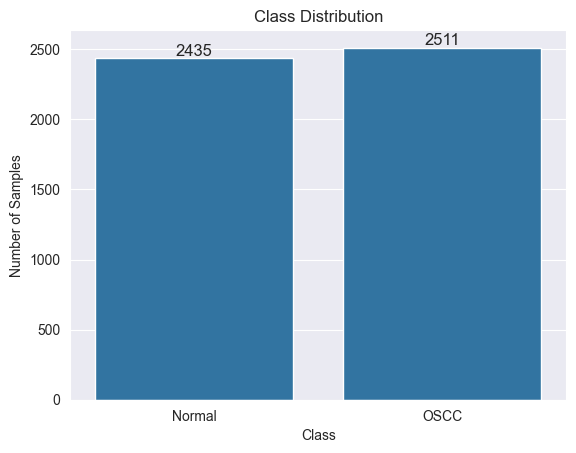

In [9]:
label_counts = np.unique(labels, return_counts=True)
class_names = ['Normal', 'OSCC']

ax = sns.barplot(x=class_names, y=label_counts[1])
for i, count in enumerate(label_counts[1]):
    ax.text(i, count + 0.05, str(count), ha='center', va='bottom', fontsize=12)
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Class")
plt.show()

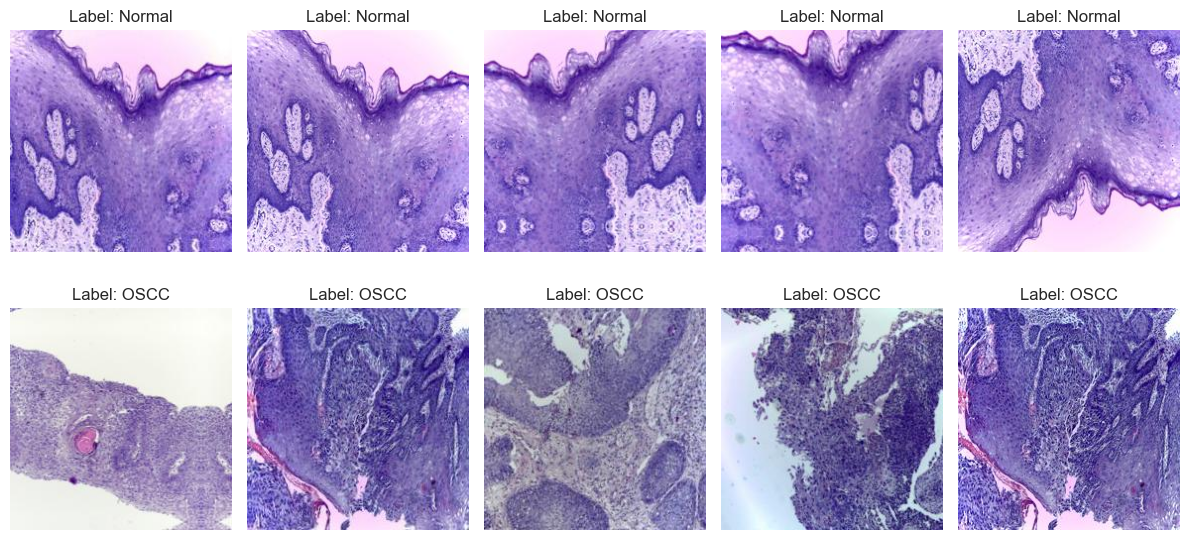

In [10]:
plt.figure(figsize=(12, 6))

# Indices for both classes
normal_indices = np.where(labels == 0)[0]
oscc_indices = np.where(labels == 1)[0]

# Display 5 images from each class
for i in range(5):
    # Plot Normal images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[normal_indices[i]])
    plt.title(f"Label: Normal")
    plt.axis("off")

    # Plot OSCC images
    plt.subplot(2, 5, i + 6)
    plt.imshow(images[oscc_indices[i]])
    plt.title(f"Label: OSCC")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [11]:
'''# Flatten images to analyze pixel distribution
pixel_values = images.ravel()  # Flatten the array
sns.histplot(pixel_values, bins=50, kde=True, color='blue')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()'''

'# Flatten images to analyze pixel distribution\npixel_values = images.ravel()  # Flatten the array\nsns.histplot(pixel_values, bins=50, kde=True, color=\'blue\')\nplt.title("Pixel Intensity Distribution")\nplt.xlabel("Pixel Value")\nplt.ylabel("Frequency")\nplt.show()'

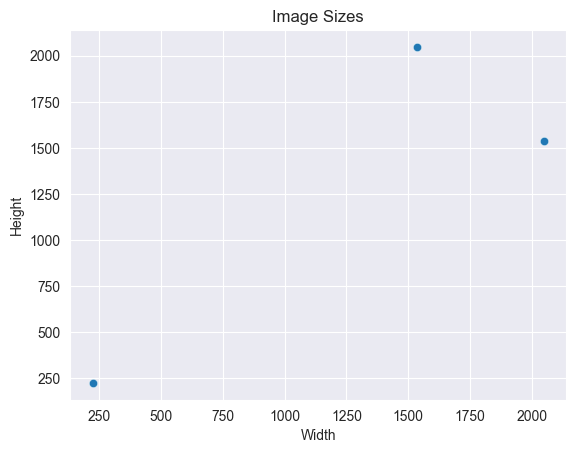

In [12]:
# Analyze the original dimensions of images
image_sizes = [Image.open(os.path.join(normal_path, f)).size for f in os.listdir(normal_path)] + \
              [Image.open(os.path.join(oscc_path, f)).size for f in os.listdir(oscc_path)]
widths, heights = zip(*image_sizes)

sns.scatterplot(x=widths, y=heights, alpha=0.5)
plt.title("Image Sizes")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()


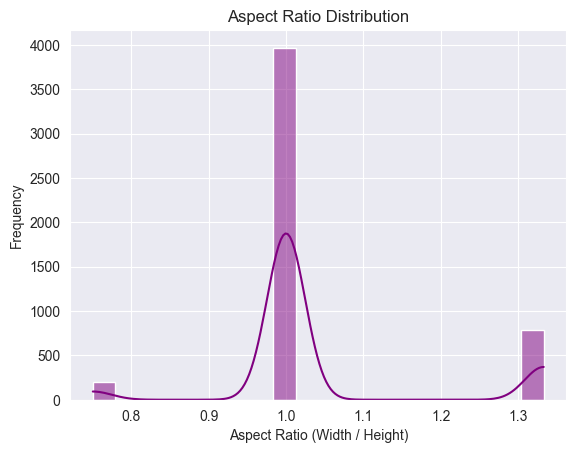

In [13]:
# Calculate aspect ratios
aspect_ratios = [w / h for w, h in zip(widths, heights)]

# Plot histogram
sns.histplot(aspect_ratios, bins=20, kde=True, color='purple')
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.show()


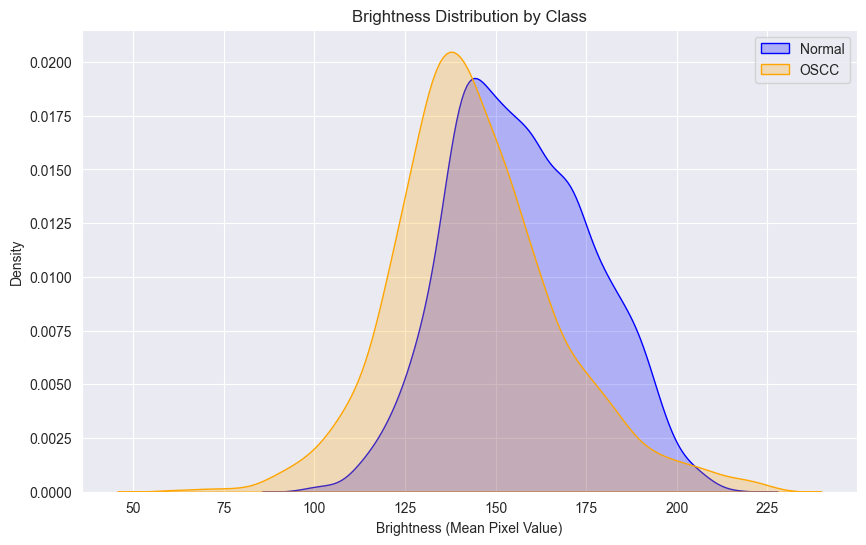

In [14]:
# Calculate brightness (mean pixel value) for each image
brightness = images.mean(axis=(1, 2, 3))

# Separate brightness by class
normal_brightness = brightness[labels == 0]
oscc_brightness = brightness[labels == 1]

# Plot brightness distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(normal_brightness, fill=True, color='blue', label='Normal')
sns.kdeplot(oscc_brightness, fill=True, color='orange', label='OSCC')
plt.title("Brightness Distribution by Class")
plt.xlabel("Brightness (Mean Pixel Value)")
plt.ylabel("Density")
plt.legend()
plt.show()


In [15]:
'''# Example augmentation pipeline using ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Select a random image for augmentation
random_image = images[0]  # Replace 0 with any index

plt.figure(figsize=(12, 6))
for i in range(9):
    augmented = datagen.random_transform(random_image)
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented)
    plt.axis("off")
plt.suptitle("Augmented Images")
plt.tight_layout()
plt.show()
'''

'# Example augmentation pipeline using ImageDataGenerator\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\n\ndatagen = ImageDataGenerator(\n    rotation_range=20,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip=True,\n    fill_mode=\'nearest\'\n)\n\n# Select a random image for augmentation\nrandom_image = images[0]  # Replace 0 with any index\n\nplt.figure(figsize=(12, 6))\nfor i in range(9):\n    augmented = datagen.random_transform(random_image)\n    plt.subplot(3, 3, i + 1)\n    plt.imshow(augmented)\n    plt.axis("off")\nplt.suptitle("Augmented Images")\nplt.tight_layout()\nplt.show()\n'

In [16]:
# Split the data: 70% training, 20% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")


Training set: 3462 images
Validation set: 994 images
Test set: 490 images


In [17]:
# Normalize images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [18]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [19]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

C:\Users\sharv\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,650 (91.20 MB)

 Trainable params: 23,907,650 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

C:\Users\sharv\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - accuracy: 0.4917 - loss: 1.9561 - val_accuracy: 0.4930 - val_loss: 0.6933
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 37s 342ms/step - accuracy: 0.4897 - loss: 0.6934 - val_accuracy: 0.5070 - val_loss: 0.6930
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 37s 339ms/step - accuracy: 0.5117 - loss: 0.6930 - val_accuracy: 0.5070 - val_loss: 0.6929
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 38s 345ms/step - accuracy: 0.5093 - loss: 0.6925 - val_accuracy: 0.5523 - val_loss: 0.6916
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 37s 340ms/step - accuracy: 0.5186 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 37s 342ms/step - accuracy: 0.5101 - loss: 0.6917 - val_accuracy: 0.5050 - val_loss: 0.6912
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 38s 346ms/step - accuracy: 0.5176 - loss: 0.6924 - val_accuracy: 0.5060 - val_loss: 0.6899
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 36s 332ms/step - accuracy: 0.5417 - loss: 0

In [21]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7740 - loss: 0.4685
Test Loss: 0.484108567237854
Test Accuracy: 0.7632653117179871


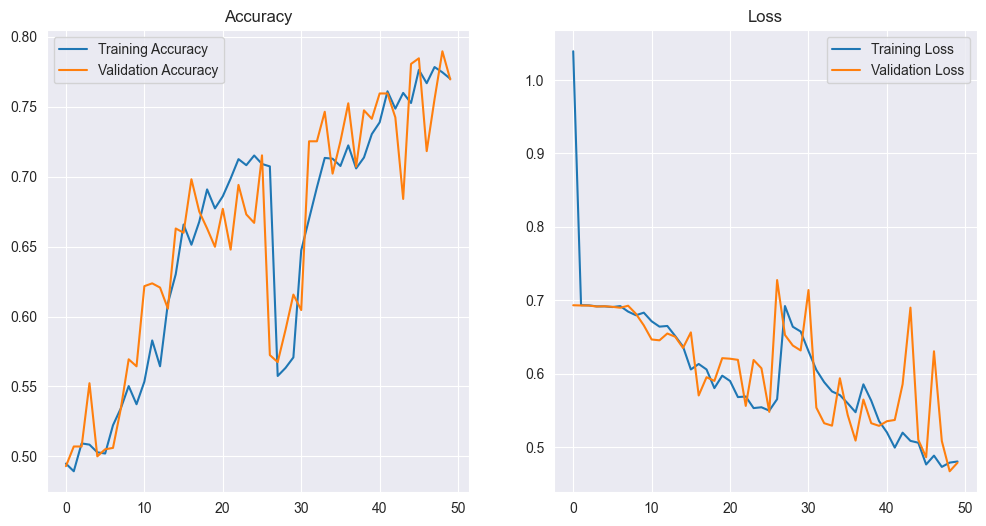

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


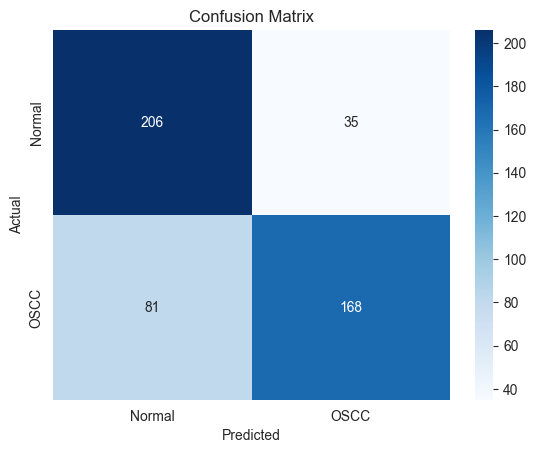

In [22]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [23]:
model.save('oral_cancer_detection_model.keras')

Biased Predictions

In [24]:
# Verify pixel value ranges
print("Training set pixel range:", X_train.min(), X_train.max())
print("Validation set pixel range:", X_val.min(), X_val.max())
print("Test set pixel range:", X_test.min(), X_test.max())

Training set pixel range: 0.0 1.0
Validation set pixel range: 0.0 1.0
Test set pixel range: 0.0 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


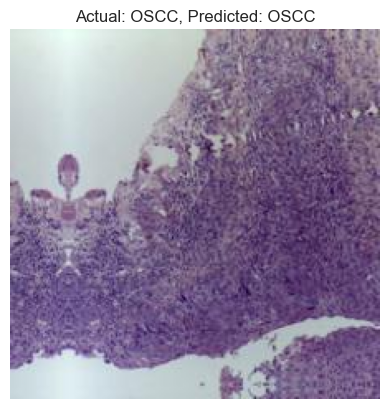

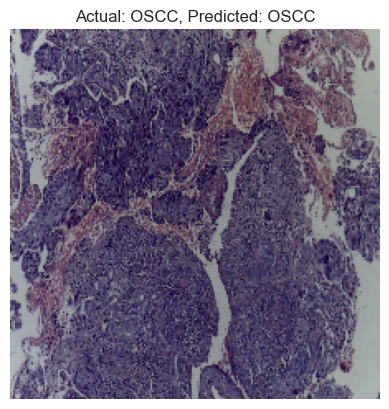

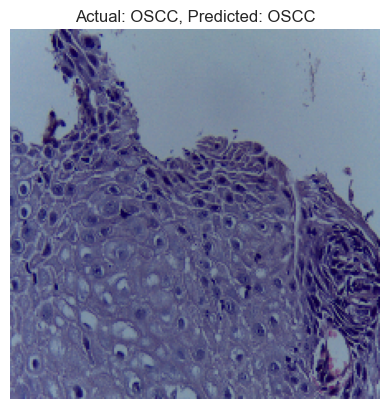

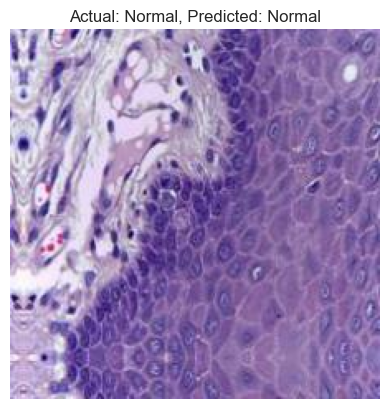

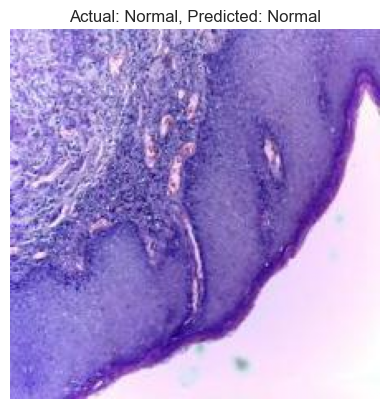

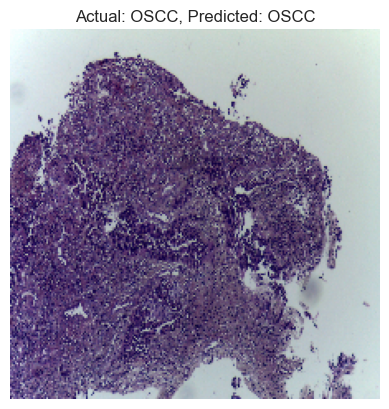

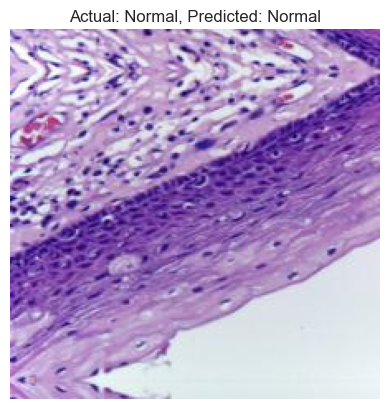

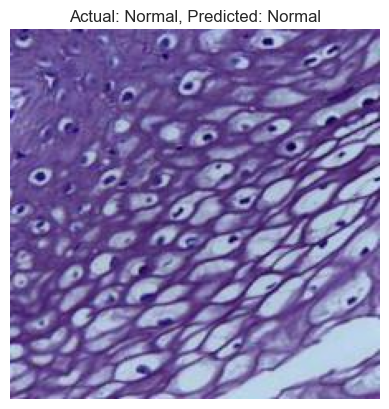

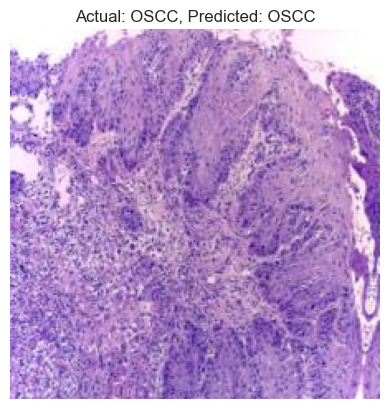

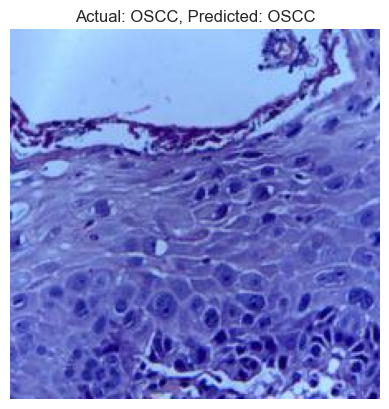

In [25]:
# Predict on a small test subset
subset_images = X_test[:10]
subset_labels = np.argmax(y_test[:10], axis=1)
predictions = np.argmax(model.predict(subset_images), axis=1)

# Display predictions with actual labels
for i in range(len(subset_images)):
    plt.imshow(subset_images[i])
    plt.title(f"Actual: {class_names[subset_labels[i]]}, Predicted: {class_names[predictions[i]]}")
    plt.axis("off")
    plt.show()